# **Redes neuronales siamesas**

## **Preparacion codigo**

### **Importando modulos necesarios**

In [1]:
from __future__ import absolute_import,division,print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image as img
import cv2
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Activation
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing import image

Using TensorFlow backend.


### **Funcion para calcular la distantica L1 punto a punto entre dos vectores y triplet loss**

In [2]:
                        
def abs_diff_output_shape(input_shapes):
  shape1, shape2, shape3= input_shapes
  return shape1


def distance_vec(y_pred): #Cosine distance
  x = y_pred[0]
  y = y_pred[1]
  z = y_pred[2]
  negative = K.prod(K.stack([x, y], axis=1), axis=1)
  return negative
  
  
  anchor = y_pred[0]
  positive = y_pred[1]
  negative = y_pred[2]

def get_abs_diff(y_pred):
    # L1 distance between two vectors
    x = y_pred[0]
    y = y_pred[1]
    z = y_pred[2]
    return K.abs(x - y)


def triple_loss(y_true, y_pred):   # y_pred contiene la imagen ancla, positiva y negativa
  alpha = 0.1
  
  anchor = y_pred[0]
  positive = y_pred[1]
  negative = y_pred[2]
    
  positive_distance = K.mean(K.square(anchor-positive),axis=-1)  #En principio mean y sum hacen lo mismo excepto que una hace media y otro suma
  negative_distance = K.mean(K.square(anchor-negative),axis=-1)
  
  loss = positive_distance - negative_distance
  return K.maximum(loss + alpha, 0)   

In [ ]:
import unittest

class TestSum(unittest.TestCase):

    def WhenIWantToGetAnImageThisMustBeRandom(self):
        img_groups = {'001' : '001'}
        group_names = list(img_groups.keys())
        image = get_random_image(img_groups,group_names,int('001'))
        self.asserEqual(image,'001001.jpg')
        
    def WhenIWantToCreateTripletThisMustBeCreated(self):
        array1 = create_triplet(1)
        array2 = ['001001.jpg','001023.jpg','004003.jpg']
        self.asserEqual(array,array2)
        
    def WhenIWantToLoadAndImageTheImageMustBeLoad(self):
        image = cv2.imread('/home/luis/dataset/' + '001' + '/' + '001')
        image = cv2.resize(image, (96, 96))
        image2 = img_to_array(image)
        image1 = load_image('001001.jpg')
        self.asserEqual(image1,image2)
    def WhenIHaveMyTripletsIWantToLoadIt(slef):
        triplets = triples_batch(image_triples)
        images = []
        for i in image_triples:
          ahs, phs, nhs= i
          images.append((load_image(ahs),load_image(phs),load_image(nhs)))
        data = np.array(images, dtype="float") / 255.0
        self.asserEqual(triplets,data)
    def WhenIWantToReshapeMyTripletsThisMustBeReshape(self):
        triples_data = create_triplet(1)
        image_cache = {}
        tr_load_train = triples_batch(tr_train)
        tr_load_train_ = reshape(tr_load_train,(96,96,3))
        self.asserEqual(tr_load_val_a.shape,(96,96,3))
    def WhenIWantToCalculateTheLoss(self):
        y_true = 1
        triples_data = create_triplet(1)
        image_cache = {}
        tr_load_train = triples_batch(tr_train)
        y_pred = reshape(tr_load_train,(96,96,3))
        loss = triple_loss(y_true, y_pred)
        self.asserEqual(loss,0)
    
    def WhenIWantToCalculateTheCosineDistance(self):
        y_true = 1
        triples_data = create_triplet(1)
        image_cache = {}
        tr_load_train = triples_batch(tr_train)
        y_pred = reshape(tr_load_train,(96,96,3))
        distance = distance_vec(y_pred)
        self.asserEqual(distance,0)

  
        
if __name__ == '__main__':
    unittest.main()

### **Funcion para crear tripletas y cargar las imagenes**



In [3]:
def get_random_image(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return gname + pname + ".jpg"
   
def create_triplet(number_images): # Crea tripleta
  img_groups = {}
  for folder in  os.listdir('/home/luis/dataset'):
    i = 0 
    for img_file in os.listdir('/home/luis/dataset/' + folder):
      if i == number_images: # Para solo coger 40 fotos
        break
      prefix, suffix = img_file.split(".")
      pid = prefix[3:]
      if folder in img_groups:
          img_groups[folder].append(pid)
      else:
          img_groups[folder] = [pid]
      i += 1
  pos_triples, neg_triples, labels = [], [], []
  # positive pairs and negative 
  group_names = list(img_groups.keys())
  for key in img_groups.keys():
    for i in range(0,number_images):
      for j in range(i+1,number_images): # Si dejo i me cogeria duplas con elementos iguales osea (001,001)
        inc = random.randrange(1, classes+1)
        dn = (int(key) + inc) % classes
        right = get_random_image(img_groups, group_names, dn)
        pos_triples.append((key + img_groups[key][i] + ".jpg", key + img_groups[key][j] + ".jpg", right))
  return pos_triples  

def load_image(image_name):
  image = cv2.imread('/home/luis/dataset/' + image_name[0:3] + '/' + image_name)
  image = cv2.resize(image, (96, 96))
  image = img_to_array(image)
  return image    
           
def triples_batch(image_triples):#, batch_size): #Tripletas
  images = []
  for i in image_triples:
      ahs, phs, nhs= i
      images.append((load_image(ahs),load_image(phs),load_image(nhs)))
  data = np.array(images, dtype="float") / 255.0
  return data


### **Crear red neuronal Convolucional**


In [12]:
def create_base_network(input_dim, classes): # SmallerVGGnet
  red = Sequential() 
  red.add(Conv2D(32, (3, 3), padding="same",input_shape=input_dim))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(MaxPooling2D(pool_size=(3, 3)))
  
  # (CONV => RELU) * 2 => POOL
  red.add(Conv2D(64, (3, 3), padding="same"))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(Conv2D(64, (3, 3), padding="same"))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(MaxPooling2D(pool_size=(2, 2)))
  
  # (CONV => RELU) * 2 => POOL
  red.add(Conv2D(128, (3, 3), padding="same"))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(Conv2D(128, (3, 3), padding="same"))
  red.add(Activation("relu"))
  red.add(BatchNormalization(axis=-1))
  red.add(MaxPooling2D(pool_size=(2, 2)))
  
	# first (and only) set of FC => RELU layers
  red.add(Flatten())
  red.add(Dense(2048))
  red.add(Activation("relu"))
  red.add(BatchNormalization())
  red.add(Dropout(0.5))

  red.add(Dense(1024))
  red.add(Activation("relu"))
  red.add(BatchNormalization())
  red.add(Dropout(0.5))

  return red 

## **Principal**

### **Inicializar datos y normalizarlos**

In [5]:
number_images = 4 # Numero de imagenes cogidas
classes = 151 # Numero de pokemones
batch = 32
nb_epoch = 10

input_dim = (96,96,3) # Son el ancho el alto y la profundidad de la imagen, 3 al ser en color es la variable input_dim pero todavia no esta tocada

### Crear varias imagenes apartir de una moviendola o rotandola

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/home/luis/dataset',  # this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        batch_size=16,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# the data, shuffled and split between train and test sets
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train = X_train.reshape(60000, input_dim)
#X_test = X_test.reshape(10000, input_dim)
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255


In [0]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/home/luis/database/108.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,save_to_dir='/home/luis/', save_prefix='1', save_format='png'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

### **Crear conjuntos de datos de entrenamiento y test** 


In [9]:
triples_data = create_triplet(number_images)

print("# image triples:", len(triples_data))

tr_train = triples_data[0:800]
tr_val = triples_data[800:906]  #El tamaño tiene que ser par (No se mucho por que)

print("# image triples:", len(tr_train))
print("# image triples:", len(tr_val))

image_cache = {}

tr_load_train = triples_batch(tr_train)
tr_load_val = triples_batch(tr_val)



# image triples: 906
# image triples: 800
# image triples: 106


In [13]:
print("# image train triples:", len(tr_train))
[x for x in tr_train[0:5]]

print("# image validation triples:", len(tr_val))
[x for x in tr_val[0:5]]

print(tr_load_train.shape)

print(tr_load_val.shape)

# image train triples: 800
# image validation triples: 106
(800, 3, 96, 96, 3)
(106, 3, 96, 96, 3)


### **Crear red siamesa** 

In [14]:
# network definition
base_network = create_base_network(input_dim, classes)
#base_network.summary()


anchor_a = Input(shape=(input_dim))   #Nos da un tensor del tamaño input_dim
anchor_p = Input(shape=(input_dim))
anchor_n = Input(shape=(input_dim))


processed_a = base_network(anchor_a)
processed_p = base_network(anchor_p)
processed_n = base_network(anchor_n)

distance = Lambda(distance_vec, output_shape=abs_diff_output_shape)([processed_a, processed_p, processed_n])

pred = Dense(1, activation = 'sigmoid')(distance)

model = Model(inputs=[anchor_a, anchor_p, anchor_n], outputs=pred)


### **Entrenar modelo**


In [17]:
def reshape(data,dim):
  data_a = data[:, 0].reshape(-1, dim[0], dim[1], dim[2])
  data_p = data[:, 1].reshape(-1, dim[0], dim[1], dim[2])
  data_n = data[:, 2].reshape(-1, dim[0], dim[1], dim[2])
  return [data_a,data_p,data_n]

#Datos de entrenamiento

tr_load_train_ = reshape(tr_load_train,input_dim)
tr_load_train_a = tr_load_train_[0]
tr_load_train_p = tr_load_train_[1]
tr_load_train_n = tr_load_train_[2]

print(tr_load_train_a.shape)
print(tr_load_train_p.shape)
print(tr_load_train_n.shape)

#Datos de validacion

tr_load_val_ = reshape(tr_load_val,input_dim)
tr_load_val_a = tr_load_val_[0]
tr_load_val_p = tr_load_val_[1]
tr_load_val_n = tr_load_val_[2]

print(tr_load_val_a.shape)
print(tr_load_val_p.shape)
print(tr_load_val_n.shape)

(800, 96, 96, 3)
(800, 96, 96, 3)
(800, 96, 96, 3)
(106, 96, 96, 3)
(106, 96, 96, 3)
(106, 96, 96, 3)


In [18]:
INIT_LR = 1e-3
EPOCHS = 100
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=triple_loss, optimizer=opt, metrics=["accuracy"])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1024)         19169152    input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [19]:
train = np.ones(len(tr_load_train))
val = np.ones(len(tr_load_val))
a = model.fit([tr_load_train_a,tr_load_train_a,tr_load_train_a], train, batch_size=batch, epochs=nb_epoch, validation_data=([tr_load_val_a,tr_load_val_p,tr_load_val_n], val))

Train on 800 samples, validate on 106 samples
Epoch 1/10
800/800 [==============================] - 52s 65ms/step - loss: 0.3647 - acc: 0.4525 - val_loss: 0.3443 - val_acc: 0.2264
Epoch 2/10
800/800 [==============================] - 51s 64ms/step - loss: 0.2573 - acc: 0.4200 - val_loss: 0.2142 - val_acc: 0.1981
Epoch 3/10
800/800 [==============================] - 52s 65ms/step - loss: 0.1850 - acc: 0.4113 - val_loss: 0.4754 - val_acc: 0.4151
Epoch 4/10
800/800 [==============================] - 50s 63ms/step - loss: 0.1909 - acc: 0.3175 - val_loss: 0.1263 - val_acc: 0.5849
Epoch 5/10
800/800 [==============================] - 50s 63ms/step - loss: 0.2047 - acc: 0.2350 - val_loss: 0.1783 - val_acc: 0.5094
Epoch 6/10
800/800 [==============================] - 50s 63ms/step - loss: 0.1956 - acc: 0.1675 - val_loss: 0.0610 - val_acc: 0.6415
Epoch 7/10
800/800 [==============================] - 51s 63ms/step - loss: 0.1616 - acc: 0.1300 - val_loss: 0.1331 - val_acc: 0.5283
Epoch 8/10
800/8

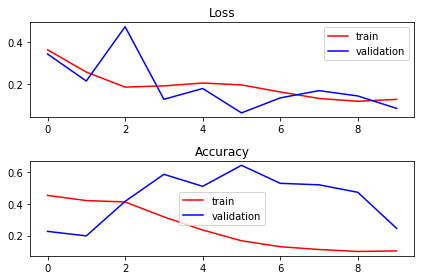

In [20]:
plt.subplot(211)
plt.title("Loss")
plt.plot(a.history["loss"], color="r", label="train")
plt.plot(a.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(a.history["acc"], color="r", label="train")
plt.plot(a.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# **Test y prueba en funcionamiento**

## **Test**

In [56]:
def load_data(name, file):
  if file == 1:
    image = cv2.imread('/home/luis/database/' + name + '.png')
  else:
    image = cv2.imread('/home/luis/' + name + '.png')
  image = cv2.resize(image, (96, 96))
  image = img_to_array(image)
  return image  

def evaluate_data(name):
  values = []
  for i in range(1,classes+1):
    images = []
    name1 = str(i)
    len_name = len(name1)
    if len_name == 1:
      name1= '00' + name1
    elif len_name == 2:
      name1= '0' + name1
    images.append((load_data(name, 0),load_data(name1, 1),load_data(name1, 1)))
    data = np.array(images, dtype="float") / 255.0
    data = reshape(data,input_dim)
    values.append(model.predict([data[0],data[1],data[2]]))
  return values

def draw_image(subplot, image, title):
    plt.subplot(subplot)
    plt.imshow(image)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
def compare(array1,array2):
    a = 0
    for i in range(1,(len(array1))):
        if array1[i] == array2[i]:
            a = a + 1
    return a

In [23]:
imagenes = ['001','002','003','004','005','006','007','008','009',
            '010','011','012','013','014','015','016','017','018','019',
            '020','021','022','023','024','025','026','027','028','029',
            '030','031','032','033','034','035','036','037','038','039',
            '040','041','042','043','044','045','046','047','048','049',
            '050','051','052','053','054','055','056','057','058','059',
            '060','061','062','063','064','065','066','067','068','069',
            '070','071','072','073','074','075','076','077','078','079',
            '080','081','082','083','084','085','086','087','088','089',
            '090','091','092','093','094','095','096','097','098','099','100']

values = []
for i in range(0,100):
    x = evaluate_data(imagenes[i])
    values.append(x)


In [60]:
aciertos = []
for i in values:
    var = 1000
    index_var = 0
    for index,j in enumerate(i):
        if j <= var:
            var = j
            index_var=index
    print(index_var,var)
    aciertos.append(index_var)
    #ref_image = plt.imread(os.path.join('/home/luis/dataset/' + index_var + '.png'))
    #draw_image(131,ref_image, "Pokemon")
    
 
#Accuracy y Matriz de confusión
imagenes = list(map(int, imagenes))
accuracy = compare(aciertos, imagenes)
print('El % de aciertos es: ', accuracy/100, '%')

0 [[4.8836355e-05]]
0 [[0.00062587]]
107 [[0.0148457]]
37 [[0.0465007]]
37 [[0.06473316]]
37 [[0.03937604]]
100 [[0.00041709]]
100 [[0.00014814]]
0 [[0.001436]]
37 [[0.0504053]]
37 [[0.11052747]]
0 [[0.0027138]]
107 [[0.06849933]]
37 [[0.10753403]]
49 [[0.01433289]]
37 [[0.18454395]]
37 [[0.08004609]]
37 [[0.03183141]]
49 [[0.01368834]]
37 [[0.10581428]]
37 [[0.06519576]]
37 [[0.02729935]]
0 [[0.00330165]]
0 [[0.00151983]]
37 [[0.14766243]]
37 [[0.09588894]]
37 [[0.09626689]]
37 [[0.09430076]]
100 [[1.5562615e-05]]
100 [[0.00014542]]
100 [[0.00017211]]
100 [[0.00107538]]
100 [[0.00313546]]
100 [[0.00717238]]
34 [[8.003998e-06]]
34 [[6.345438e-05]]
58 [[0.11666754]]
37 [[0.00074488]]
100 [[0.0005252]]
0 [[0.00041907]]
34 [[0.01607562]]
107 [[0.03461677]]
37 [[0.02882623]]
37 [[0.02547685]]
100 [[0.00665937]]
37 [[0.0500854]]
0 [[0.01307755]]
100 [[0.00243916]]
100 [[0.01667038]]
0 [[0.00017656]]
0 [[0.00100442]]
49 [[0.01535733]]
49 [[0.02721876]]
0 [[0.00214965]]
100 [[0.00081126]]
107